In [1]:
# showing plots for data from 3/24/25
# the time sweeping data was collected with 3 probes, collecting I_DS
# this data was DMF-based APTAMER functionalization on b4d3
# the time series data was done using 3 channels
# the timeseries was done with 0.1X PBS
# the funcionalization was done using ETA as quenchers

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [7]:
# filenames

# filenames for functionalization
filenames_1_func = ['data/data_25-03-24/b4d5a-id.csv', 
                 'data/data_25-03-24/b4d5a-pbase.csv', 
                 'data/data_25-03-24/b4d5a-apt.csv',
                 'data/data_25-03-24/b4d5a-eta.csv',]

filenames_2_func = ['data/data_25-03-24/b4d5b-id.csv', 
                 'data/data_25-03-24/b4d5b-pbase.csv', 
                 'data/data_25-03-24/b4d5b-apt.csv',
                 'data/data_25-03-24/b4d5b-eta.csv',]

filenames_3_func = ['data/data_25-03-24/b4d5d-id.csv', 
                 'data/data_25-03-24/b4d5d-pbase.csv', 
                 'data/data_25-03-24/b4d5d-apt.csv',
                 'data/data_25-03-24/b4d5d-eta.csv',]


In [8]:
def load_csv_data_1ch(filenames):
    '''
    for multiple file
    works for cases where time sweeps have different number of samples 
    '''
    data_list = []
    for filename in filenames:
        data_device = np.genfromtxt(filename, delimiter=',', skip_header=1, filling_values=np.nan).T[[6, 4], :]
        data_device = np.nan_to_num(data_device)
        data_device[1,:] *= 1000.0
        num_time_samples = data_device.shape[-1]
        data_list.append(data_device[:,-1*num_time_samples//2:][:, ::-1]) # 2/3 here because right bound dipped below dirac current

    # list of elements of shape (voltages/currents), voltage_sweep, 
    # index is device_num
    
    return data_list



def get_dirac_points(IV_list):
    dirac_ivs_list = []
    for IV_mx in IV_list:
        dirac_idx = np.argmin(IV_mx[1])
        dirac_iv = IV_mx[:,dirac_idx]
        dirac_ivs_list.append(dirac_iv)
    return np.array(dirac_ivs_list)


data_1 = load_csv_data_1ch(filenames_1_func)
data_1_dirac = get_dirac_points(data_1)

data_2 = load_csv_data_1ch(filenames_2_func)
data_2_dirac = get_dirac_points(data_2)

data_3 = load_csv_data_1ch(filenames_3_func)
data_3_dirac = get_dirac_points(data_3)

print(len(data_1), data_1[0].shape, data_1_dirac.shape)
print(len(data_2), data_2[0].shape, data_2_dirac.shape)
print(len(data_3), data_3[0].shape, data_3_dirac.shape)


4 (2, 201) (4, 2)
4 (2, 201) (4, 2)
4 (2, 201) (4, 2)


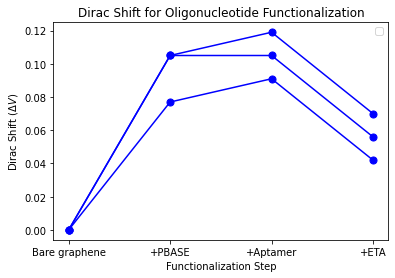

In [10]:
def plot_func_steps(dirac_mx_func_list, title):
    '''
    No blanks, func'd with all of the same bioreceptor
    '''

    xlabels = ['Bare graphene', '+PBASE', '+Aptamer', '+ETA']
    colors = ['blue', 'red', 'orange']
    for dev_num in range(len(dirac_mx_func_list)):
        
        plt.scatter(range(dirac_mx_func_list[dev_num][:,0].size), dirac_mx_func_list[dev_num][:,0] - dirac_mx_func_list[dev_num][0,0], s=50, color=colors[0])
        plt.plot(range(dirac_mx_func_list[dev_num][:,0].size), dirac_mx_func_list[dev_num][:,0] - dirac_mx_func_list[dev_num][0,0], color=colors[0])
        
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = {}
    for handle, label in zip(handles, labels):
        if label not in unique:
            unique[label] = handle
    # sorted_unique = dict(sorted(unique.items(), key=lambda x: x[0]))
    # plt.legend(sorted_unique.values(), sorted_unique.keys())
    plt.legend(unique.values(), unique.keys())

    plt.xlabel('Functionalization Step')
    plt.ylabel(rf'Dirac Shift $(\Delta V)$')
    plt.title(title)
    plt.xticks(range(len(xlabels)), xlabels)
    plt.show()
    plt.close()

plot_func_steps([data_1_dirac, data_2_dirac, data_3_dirac], 'Dirac Shift for Oligonucleotide Functionalization')

0.000237028 0.000245308


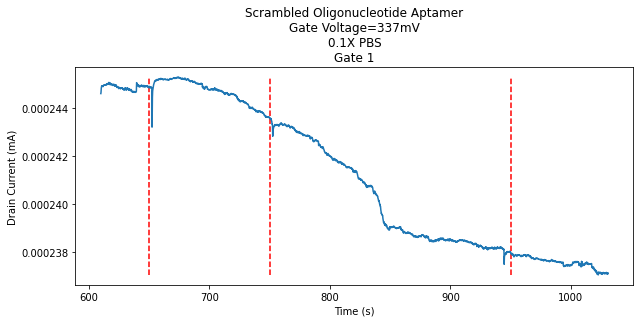

0.000571468 0.000586868


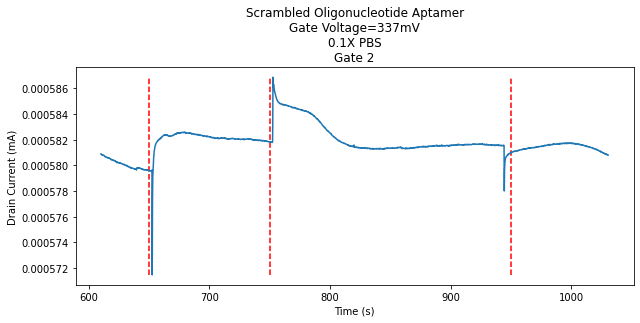

0.000430456 0.000443015


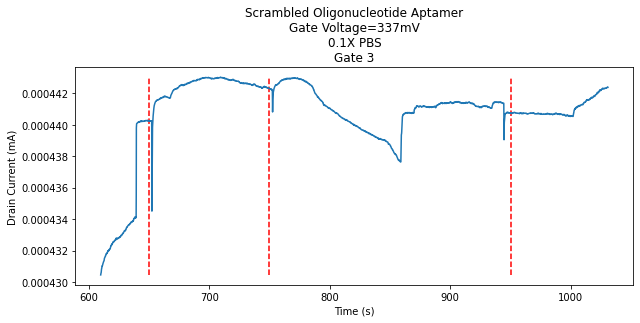

--------------------------------------------------------------------------------
0.000251054 0.000253062


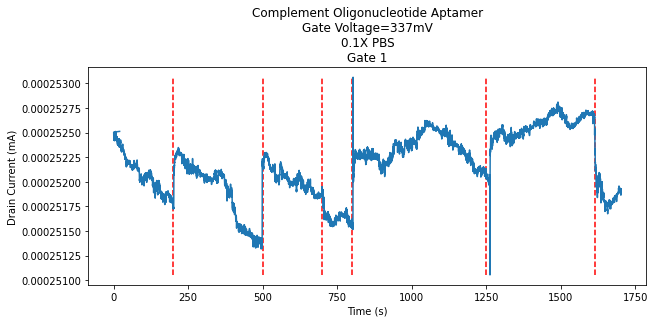

0.000486465 0.000569072


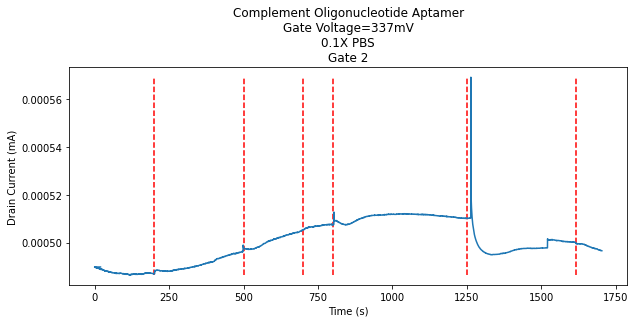

0.000453486 0.000478809


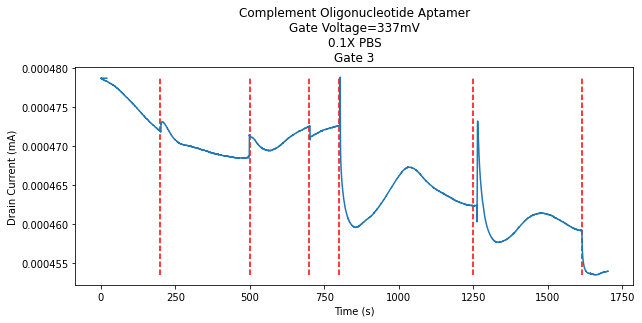

In [23]:
def plot_time_series_3ch(file_path, max_time_sample, min_time_sample=0, xval_action_list=[], title=''):
    '''
    3 probes are used at once, with 2 source meters
    column / channel
    3 = device 1 channel 1
    6 = device 1 channel 2
    9 = device 2 channel 1
    (device 2 channel 2 is the gate)
    '''
    data_timesweep = np.genfromtxt(file_path, delimiter=",", dtype=np.float64, filling_values=np.nan)
    
    data_timesweep_time = data_timesweep[1+min_time_sample:max_time_sample,4].T
    data_timesweep_currents = data_timesweep[1+min_time_sample:max_time_sample,[3, 6, 9]].T
    data_timesweep[1,:] *= 1000.0

    for dev_num in range(len(data_timesweep_currents)):
        plt.figure(figsize=(10, 4))
        
        minim = np.min(data_timesweep_currents[dev_num])
        maxim = np.max(data_timesweep_currents[dev_num])
        print(minim, maxim)
        for xval in xval_action_list:
            if xval < min_time_sample//10: continue
            plt.plot([xval, xval], [minim, maxim], color='r', linestyle='--')
        
        plt.plot(data_timesweep_time, data_timesweep_currents[dev_num])
        plt.xlabel('Time (s)')
        plt.ylabel('Drain Current (mA)')
        plt.title(title + f'\nGate {dev_num+1}')
        plt.show()
        plt.close()


file_path = 'data/data_25-03-24/b4d5abd-timeseries-scrambled.csv'
max_time_sample = 10310
min_time_sample = 6100
xval_action_list = [240, 500, 650, 750, 950]
title = 'Scrambled Oligonucleotide Aptamer\nGate Voltage=337mV\n0.1X PBS'
plot_time_series_3ch(file_path=file_path, 
                     max_time_sample=max_time_sample, 
                     min_time_sample=min_time_sample,
                     xval_action_list=xval_action_list, 
                     title=title)

print('--------------------------------------------------------------------------------')

file_path = 'data/data_25-03-24/b4d5-timeseries-complement.csv'
max_time_sample = 17028
min_time_sample = 0
xval_action_list = [200, 500, 800, 1250, 1615, 700]
title = 'Complement Oligonucleotide Aptamer\nGate Voltage=337mV\n0.1X PBS'
plot_time_series_3ch(file_path=file_path, 
                     max_time_sample=max_time_sample, 
                     min_time_sample=min_time_sample,
                     xval_action_list=xval_action_list, 
                     title=title)

In [20]:
# def get_current_diff(file_path, time1, time2):
#     data_timesweep = np.genfromtxt(file_path, delimiter=",", dtype=np.float64, filling_values=np.nan)
    
#     data_timesweep_time = data_timesweep[1+min_time_sample:max_time_sample,4].T
#     data_timesweep_currents = data_timesweep[1+min_time_sample:max_time_sample,[3, 6, 9]].T
#     data_timesweep[1,:] *= 1000.0
    





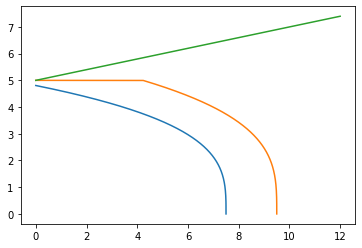